<a href="https://colab.research.google.com/github/QAppleData/DL_final_project/blob/main/DeepLearningProject_Applegate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prediction RNN 

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. I will predict Apple's stock price 5 days in advance.

The particular network architecture I will employ for my RNN is LSTM, which helps significantly avoid technical problems with optimization of RNNs.

## Step 1: Loading the data

Load in the time series - a history of around 140 days of Apple's stock price. A few pre-processing steps needed to prepare it for use with an RNN model.  First to normalize time series by its range to lie in the range [0,1].

In [3]:
# download the data
!wget https://raw.githubusercontent.com/QAppleData/DL_final_project/main/all_stocks_5yr.csv

--2020-12-06 21:44:08--  https://raw.githubusercontent.com/QAppleData/DL_final_project/main/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24591135 (23M) [text/plain]
Saving to: ‘all_stocks_5yr.csv’

all_stocks_5yr.csv  100%[===================>]  23.45M  81.8MB/s    in 0.3s    

2020-12-06 21:44:09 (81.8 MB/s) - ‘all_stocks_5yr.csv’ saved [24591135/24591135]



In [4]:
!ls .

all_stocks_5yr.csv  sample_data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [5]:
# Importing the training set
dataset = data = pd.read_csv('./all_stocks_5yr.csv')
# Create a np array the close values 
dataset_cl = dataset[dataset['Name']=='AAPL'].close.values

In [6]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

## Step 2:  Cutting our time series into sequences

A time series is a sequence of numbers that can be represented in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply RNN, the time series prediction problem needs to be treated as a regression problem. So use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

Using a window of size T = 5, a set of input/output pairs like the one shown in the table was created. Each input is a sequence (or vector) of length 4 while each corresponding output is a scalar value.A given time series of length P and window size T = 5 as shown above, the correspoinding P - 5 input/output pairs are shown in the table below.  

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$



In [7]:
#Create a function to process the data into 7 day look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(dataset_cl, 5)


## Step 3: Split training and testing sets

In order to perform proper evaluation on the dataset, the last 1/3 of which was designated for validation. The dataset could not be split randomly as common cases would do when validating a regression model, because the input/output pairs are related temporally. The design was to train model on one solid chunk of the series (in this case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how the model would predict future values of a time series.

In [8]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

1002
251
1002
251


## Step 4:  Build and run an RNN regression model

Build a two hidden layer RNN of the following steps:

- layer 1 (input) uses an LSTM module with 5 hidden units (the input_shape = (window_size,1))
- layer 2 (hidden)uses a fully connected module with 100 units, output layer 1 unit
- the 'mean_squared_error' loss function

In [9]:
# create RNN model
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state

In [10]:
# Globals

INPUT_SIZE = 5
HIDDEN_SIZE = 100
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001 # also tested with 0.0001, 0.01
num_epochs = 800 # also tested with 400, 600

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [11]:
rnn #take a look

RNN(
  (rnn): LSTM(5, 100, num_layers=3, dropout=0.1)
  (out): Linear(in_features=100, out_features=1, bias=True)
)

In [12]:
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters
    
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.19392742216587067, eval loss 0.7070362567901611
epoch 1, loss 0.16502614319324493
epoch 2, loss 0.1387166529893875
epoch 3, loss 0.11384646594524384
epoch 4, loss 0.0891270861029625
epoch 5, loss 0.06513737887144089
epoch 6, loss 0.042042315006256104
epoch 7, loss 0.023969238623976707
epoch 8, loss 0.023365093395113945
epoch 9, loss 0.044067490845918655
epoch 10, loss 0.041684750467538834
epoch 11, loss 0.030577383935451508
epoch 12, loss 0.022895721718668938
epoch 13, loss 0.02092396840453148
epoch 14, loss 0.022461196407675743
epoch 15, loss 0.02439301274716854
epoch 16, loss 0.026180338114500046
epoch 17, loss 0.027405215427279472
epoch 18, loss 0.02734321914613247
epoch 19, loss 0.026538966223597527
epoch 20, loss 0.025126321241259575, eval loss 0.20504198968410492
epoch 21, loss 0.023435650393366814
epoch 22, loss 0.02108209952712059
epoch 23, loss 0.018968380987644196
epoch 24, loss 0.017511555925011635
epoch 25, loss 0.016640471294522285
epoch 26, loss 0.01674617

## Step 5:  Model Performance Evaluation

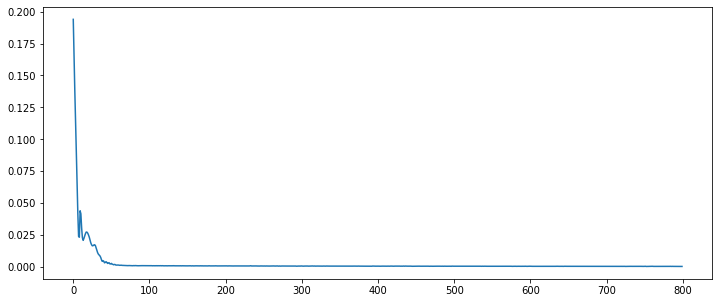

In [13]:
#Plot training histroy
plt.figure(figsize=(12,5))
plt.plot(history)
# dplt.plot(history.history['val_loss'])

In [14]:
X_test[0]# Take a look at test results

array([[0.5909131 , 0.5891313 , 0.59358582, 0.60338576, 0.61342868]])

In [15]:
# Switch to eval mode
rnn.eval()

test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [16]:
test_predict_cpu.shape #check output shape

(251, 1, 1)

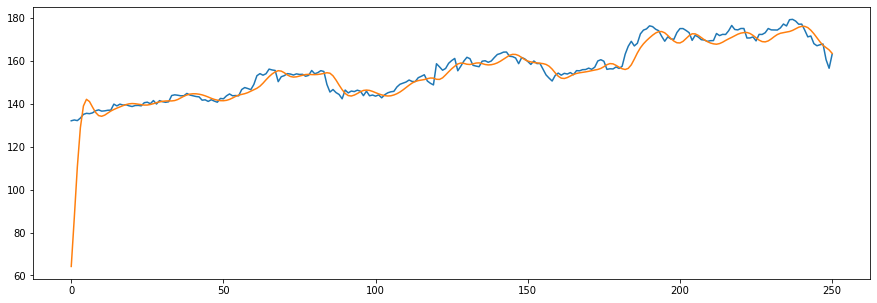

In [17]:
# Plot preicted vs test
plt.figure(figsize=(15,5))
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))#blue
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))#orange

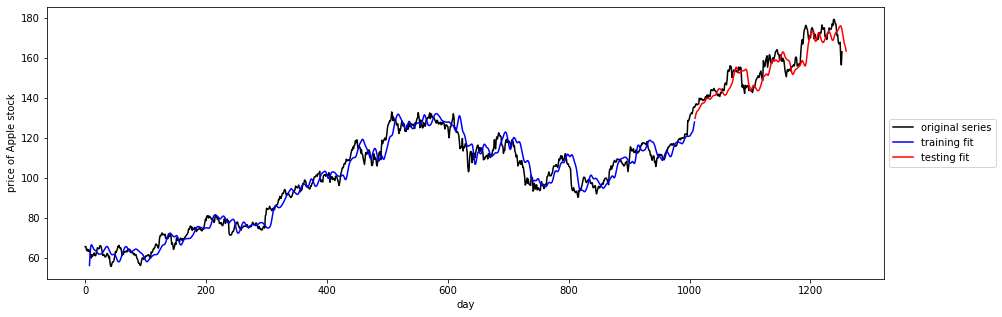

In [18]:
# plot original data
plt.figure(figsize=(15,5))
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph

plt.xlabel('day')
plt.ylabel('price of Apple stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
